### 微调

微调由以下4部构成:
1. 在源数据集(如ImageNet数据集)上预训练一个神经网络模型，即源模型。
2. 创建一个新的神经网络模型，即目标模型。它复制了源模型上除了输出层外的所有模型设计及其训练好的参数。
3. 为目标模型添加一个输出大小为目标数据集类别个数的输出层，并随机初始化该层的模型参数。
4. 在目标数据集(如椅子数据集)上训练目标模型。我们将从头训练输出层，而其余层的参数都是基于源模型的参数微调得到的。

当目标数据集远小于源数据集时，微调有助于提升模型的泛化能力。
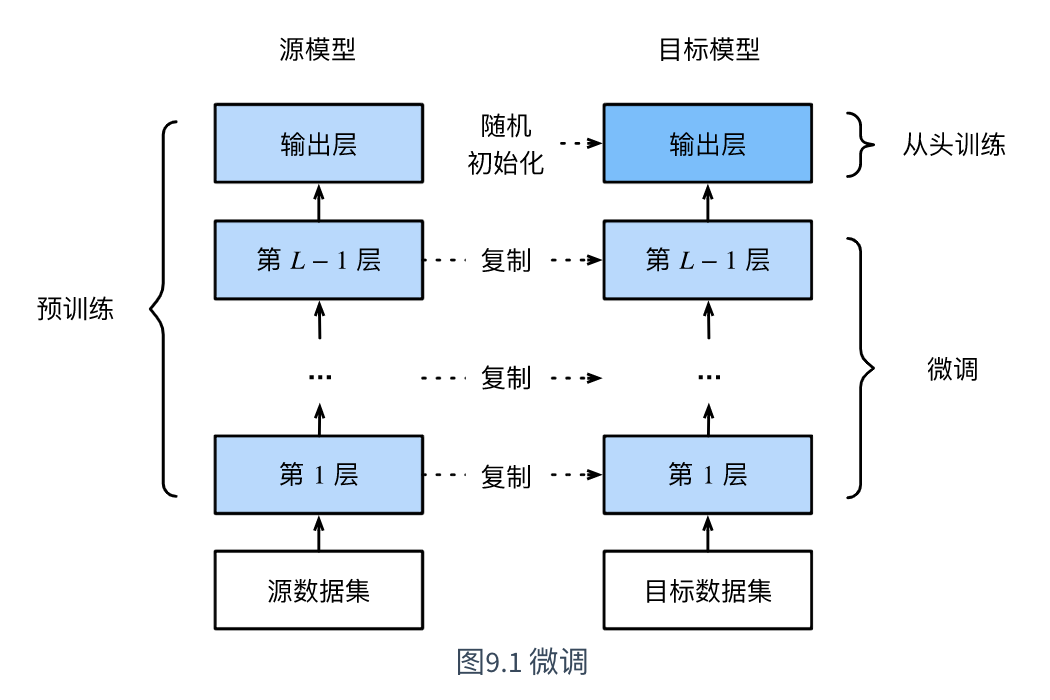

**一般来说，微调参数会使用较小的学习率，而从头训练输出层可以使用较大的学习率**

### 热狗识别

实践一个具体的例子:热狗识别。我们将基于一个小数据集对在ImageNet数据集上训练好的ResNet-18模型进行微调。



In [1]:
#导入相关的包或模块
import torch
from torch import nn,optim
from torch.utils.data import Dataset,DataLoader
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models
import os
import utils
import time
import sys

In [2]:
#指定训练设备
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
#获取数据集
#hotdog下有train和test两个文件夹
#这两个文件夹下面均有hotdog和not-hotdog两个文件夹

data_dir='/home/wushukun/jupyterHome/remotePython/DeepLearning/Dataset'
#我们创建两个ImageFolder实例来分别读取训练数据集合测试数据集
#ImageFolder返回二维数组，第一维为图片索引，
#train_imgs[i][0]返回PIL图像,train_imgs[i][1]返回图像的标签
train_imgs=ImageFolder(os.path.join(data_dir,'hotdog/train'))
test_imgs=ImageFolder(os.path.join(data_dir,'hotdog/test'))


**注：在使用预训练模型时，一定要和预训练时作同样的预处理**
下面使用torchvision.models就要求:

* 输出的图像为长宽最小为225
* 所有图像初始化范围为[0,1]
* 所有图像采用mean=[0.4,0.456,0.406]和std=[0.229,0.224,0.225]进行标准化


In [4]:
#对图像进行预处理
normalize=transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
train_augs=transforms.Compose([
    transforms.RandomResizedCrop(size=224),#对图像随机裁剪224大小和随机高宽比
    transforms.RandomHorizontalFlip(),#对图像进行随机水平翻转
    transforms.ToTensor(),#转换为Tensor同时范围统一为[0,1]
    normalize
])
#测试时，将图像缩放为256像素
#然后从中裁剪出高和宽均为224像素的中心区域作为输入
test_augs=transforms.Compose([
    transforms.Resize(size=256),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    normalize
])

接下来我们使用在ImageNet数据集上预训练的ResNet-18作为源模型。
这里指定pretrained=Treu来自动下载并加载预训练的模型参数。

In [5]:
#加载预训练ResNet-18模型
pretrained_net=models.resnet18(pretrained=True)

print(pretrained_net.fc)

Linear(in_features=512, out_features=1000, bias=True)


In [6]:
#改变最后的输出层
#此时最后的fc层就被随机初始化了，但是其他层依然保存着预训练得到的参数
pretrained_net.fc=nn.Linear(512,2)
print(pretrained_net.fc)

Linear(in_features=512, out_features=2, bias=True)


In [8]:
#将fc的学习率设为已经预训练过的部分的10倍

#对所有参数使用id()函数
output_params=list(map(id,pretrained_net.fc.parameters()))
#过滤掉不是fc层的参数
features_params=filter(lambda p:id(p) not in output_params, pretrained_net.parameters())

lr=0.01
optimizer = optim.SGD(pretrained_net.parameters(), lr=lr, weight_decay=0.001)
# optimizer=optim.SGD(
#     [
#         {'params':features_params},
#         {'params':pretrained_net.fc.parameters(),'lr':lr*10}
#     ],
#     lr=lr,weight_decay=0.001
# )

In [9]:
#定义评估函数
def evaluate_accuracy(data_iter,net,device=None):
    if device is None and isinstance(net,nn.Module):
        device=list(net.parameters())[0].device
    acc_sum,n=0.0,0
    with torch.no_grad():
        for X,y in data_iter:
            net.eval() #评估模式，关闭dropout
            acc_sum+=(net(X.to(device)).argmax(dim=1)==y.to(device)).float().sum().cpu().item()
            net.train()
            n+=y.shape[0]
    return acc_sum/n

In [10]:
#定义训练函数
def train(train_iter,test_iter,net,loss,optimizer,device,num_epochs):
    net=net.to(device)
    print('trianing on',device)
    batch_count=0
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n,start=0.0,0.0,0,time.time()
        for X,y in train_iter:
            X=X.to(device)
            y=y.to(device)
            y_hat=net(X)
            l=loss(y_hat,y)
            optimizer.step()
            train_l_sum+=l.cpu().item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).float().sum().cpu().item()
            n+=y.shape[0]
            batch_count+=1
        test_acc=evaluate_accuracy(test_iter,net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))

In [11]:
#定义微调训练函数
def train_fine_tuning(net,optimizer,batch_size=128,num_epochs=5):
    train_iter=DataLoader(ImageFolder(os.path.join(data_dir,'hotdog/train'),transform=train_augs),batch_size,shuffle=True)
    test_iter=DataLoader(ImageFolder(os.path.join(data_dir,'hotdog/test'),transform=test_augs),batch_size)
    loss=torch.nn.CrossEntropyLoss()
    train(train_iter,test_iter,net,loss,optimizer,device,num_epochs)

In [12]:
train_fine_tuning(pretrained_net,optimizer)

trianing on cuda
epoch 1, loss 0.7636, train acc 0.534, test acc 0.531, time 16.6 sec
epoch 2, loss 0.3816, train acc 0.529, test acc 0.522, time 16.8 sec
epoch 3, loss 0.2546, train acc 0.528, test acc 0.521, time 16.6 sec
epoch 4, loss 0.1905, train acc 0.533, test acc 0.519, time 16.4 sec
epoch 5, loss 0.1534, train acc 0.521, test acc 0.521, time 16.7 sec


In [12]:
scratch_net = models.resnet18(pretrained=False, num_classes=2)
print(scratch_net.fc)
lr = 0.1
optimizer = optim.SGD(scratch_net.parameters(), lr=lr, weight_decay=0.001)
train_fine_tuning(scratch_net, optimizer)

Linear(in_features=512, out_features=2, bias=True)
trianing on cuda
epoch 1, loss 0.7093, train acc 0.496, test acc 0.499, time 16.3 sec
epoch 2, loss 0.3536, train acc 0.498, test acc 0.500, time 16.2 sec
epoch 3, loss 0.2356, train acc 0.506, test acc 0.505, time 16.1 sec
epoch 4, loss 0.1762, train acc 0.508, test acc 0.502, time 16.4 sec
epoch 5, loss 0.1406, train acc 0.511, test acc 0.504, time 16.7 sec
